In [ ]:
# ML Web Scraper Model for E-Commerce Product Analysis
# This notebook implements a machine learning pipeline to extract product information
# from HTML pages with different structures

import pandas as pd
import numpy as np
import requests
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import json
from urllib.parse import urlparse
import warnings
warnings.filterwarnings('ignore')

# First, we'll create functions to prepare the training data

def download_page(url, timeout=10):
    """Download HTML content from URL with proper headers"""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    try:
        response = requests.get(url, headers=headers, timeout=timeout)
        response.raise_for_status()
        return response.text
    except Exception as e:
        print(f"Error downloading {url}: {str(e)}")
        return None

def extract_domain(url):
    """Extract the domain from a URL"""
    parsed_uri = urlparse(url)
    return parsed_uri.netloc

def extract_features_from_tag(tag):
    """Extract features from a BeautifulSoup tag"""
    features = {
        'tag_name': tag.name,
        'class': ' '.join(tag.get('class', [])),
        'id': tag.get('id', ''),
        'text_length': len(tag.get_text(strip=True)),
        'has_price': 1 if re.search(r'(\$|€|£|\d+\.\d{2})', tag.get_text()) else 0,
        'has_product_term': 1 if re.search(r'product|item|buy|purchase|cart|shop', tag.get_text().lower()) else 0,
        'has_img': 1 if tag.find('img') else 0,
        'has_link': 1 if tag.find('a') else 0,
        'depth': len(list(tag.parents)),
        'child_count': len(tag.contents),
        'sibling_count': len(list(tag.next_siblings)) + len(list(tag.previous_siblings))
    }
    return features

def generate_training_data(html_samples, domain_categories):
    """Generate training data from HTML samples"""
    all_data = []
    
    for idx, (url, html) in enumerate(html_samples.items()):
        if not html:
            continue
            
        domain = extract_domain(url)
        domain_type = domain_categories.get(domain, 'other')
        
        soup = BeautifulSoup(html, 'html.parser')
        
        # Select promising elements for classification
        candidates = soup.select('div, li, article, section')
        
        for tag in candidates:
            # Skip very small tags
            if len(tag.get_text(strip=True)) < 10:
                continue
                
            features = extract_features_from_tag(tag)
            
            # Label as product container if it likely contains product info
            is_product = 0
            text = tag.get_text().lower()
            
            # Determine if this tag is likely a product container
            if (features['has_price'] == 1 and 
                ('buy' in text or 'add to cart' in text or re.search(r'product|item', tag.get('class', [''])[0] if tag.get('class') else ''))):
                is_product = 1
                
            features['domain_type'] = domain_type
            features['is_product'] = is_product
            features['html_structure'] = str(tag)[:1000]  # Store part of HTML for reference
            
            all_data.append(features)
    
    return pd.DataFrame(all_data)

# 1. Download some e-commerce pages for training

print("Preparing to download sample e-commerce pages for model training...")

# List of popular e-commerce sites and their category
ecommerce_urls = {
    'https://example-electronics-store.com': 'electronics',
    'https://example-bookstore.com': 'books',
    'https://example-fashion-store.com': 'fashion',
    'https://example-home-goods.com': 'home',
    'https://example-general-ecommerce.com': 'general'
}

# For this notebook, we'll create synthetic data rather than actually downloading

print("Using synthetic data for demonstration purposes...")

# Create synthetic HTML structures for different e-commerce types
def generate_synthetic_html(domain_type):
    """Generate synthetic HTML for different types of e-commerce sites"""
    product_class = f"product-container-{domain_type}"
    price_class = f"price-{domain_type}"
    
    if domain_type == 'electronics':
        product_template = f"""
        <div class="{product_class}">
            <div class="image-container"><img src="product.jpg" alt="Product"></div>
            <h3 class="product-title">Electronics Product</h3>
            <div class="{price_class}">$299.99</div>
            <div class="rating">★★★★☆</div>
            <button class="add-to-cart">Add to Cart</button>
        </div>
        """
    elif domain_type == 'books':
        product_template = f"""
        <li class="{product_class}">
            <div class="book-cover"><img src="book.jpg" alt="Book"></div>
            <div class="book-info">
                <h4>Book Title</h4>
                <p class="author">Author Name</p>
                <span class="{price_class}">$15.99</span>
            </div>
            <a href="#" class="buy-now">Buy Now</a>
        </li>
        """
    elif domain_type == 'fashion':
        product_template = f"""
        <article class="{product_class}">
            <figure class="product-image">
                <img src="fashion.jpg" alt="Fashion item">
            </figure>
            <div class="product-details">
                <h3>Fashion Item Name</h3>
                <div class="{price_class}">$49.95</div>
                <div class="color-options">
                    <span class="color red"></span>
                    <span class="color blue"></span>
                </div>
            </div>
            <button class="add-to-bag">Add to Bag</button>
        </article>
        """
    elif domain_type == 'home':
        product_template = f"""
        <div class="{product_class}">
            <img src="home-item.jpg" alt="Home item">
            <h4 class="item-name">Home Decor Item</h4>
            <div class="item-details">
                <span class="{price_class}">$79.99</span>
                <span class="availability">In Stock</span>
            </div>
            <a href="#" class="view-details">View Details</a>
        </div>
        """
    else:  # general
        product_template = f"""
        <div class="{product_class}">
            <div class="product-image">
                <img src="product.jpg" alt="Product">
            </div>
            <div class="product-info">
                <h3>Product Name</h3>
                <div class="{price_class}">$39.99</div>
                <div class="product-rating">4.5/5</div>
            </div>
            <button class="buy-button">Buy Now</button>
        </div>
        """
    
    # Create a page with multiple products
    products = ""
    for i in range(10):
        products += product_template.replace('Product Name', f'Product Name {i+1}')
    
# Generate synthetic HTML for each domain type
html_samples = {}
domain_categories = {}

for url, category in ecommerce_urls.items():
    domain = extract_domain(url)
    html_samples[url] = generate_synthetic_html(category)
    domain_categories[domain] = category

print(f"Generated synthetic HTML for {len(html_samples)} e-commerce site types")

# Generate training data from our synthetic HTML
print("Generating training features from HTML structures...")
training_data = generate_training_data(html_samples, domain_categories)

print(f"Generated {len(training_data)} training samples")
print(f"Positive examples (product containers): {training_data['is_product'].sum()}")
print(f"Negative examples (non-product elements): {len(training_data) - training_data['is_product'].sum()}")

# Feature engineering - convert categorical variables to numerical
# Text features can be processed with TF-IDF
print("Performing feature engineering...")

# Process tag structure with TF-IDF
vectorizer = TfidfVectorizer(max_features=100)
html_features = vectorizer.fit_transform(training_data['html_structure'])

# One-hot encode domain type
domain_dummies = pd.get_dummies(training_data['domain_type'], prefix='domain')

# One-hot encode tag_name
tag_dummies = pd.get_dummies(training_data['tag_name'], prefix='tag')

# Combine all features
features = pd.concat([
    # Only include numeric features
    training_data[['text_length', 'has_price', 'has_product_term', 'has_img', 'has_link', 
                   'depth', 'child_count', 'sibling_count']],
    # Add encoded categorical features
    domain_dummies,
    tag_dummies,
    pd.DataFrame(html_features.toarray(), columns=[f"html_feat_{i}" for i in range(html_features.shape[1])])
], axis=1)

if 'class' in training_data.columns:
    class_vectorizer = TfidfVectorizer(max_features=50)
    class_features = class_vectorizer.fit_transform(training_data['class'].fillna(''))
    features = pd.concat([features, 
                         pd.DataFrame(class_features.toarray(), 
                                     columns=[f"class_feat_{i}" for i in range(class_features.shape[1])])], 
                         axis=1)

if 'id' in training_data.columns:
    # For id, just check if present
    features['has_id'] = training_data['id'].apply(lambda x: 0 if pd.isna(x) or x == '' else 1)

# Prepare for training
X = features
y = training_data['is_product']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Train a Random Forest classifier
print("Training Random Forest classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("\nModel Evaluation:")
print(classification_report(y_test, y_pred))

# Save the model and vectorizer
print("Saving model and feature engineering components...")
joblib.dump(model, 'product_container_model.pkl')
joblib.dump(vectorizer, 'html_vectorizer.pkl')

# Feature importance analysis
feature_importances = pd.DataFrame({
    'feature': features.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importances.head(10))

# Now define a function to use the trained model to analyze new pages

def extract_product_tags(html, url):
    """Use trained model to extract product containers from a new page"""
    domain = extract_domain(url)
    domain_type = domain_categories.get(domain, 'other')  
    
    soup = BeautifulSoup(html, 'html.parser')
    candidates = soup.select('div, li, article, section')
    
    results = {
        'product_containers': [],
        'price_tags': [],
        'name_tags': [],
        'image_tags': [],
        'button_tags': []
    }
    
    for tag in candidates:
        # Skip very small tags
        if len(tag.get_text(strip=True)) < 10:
            continue
            
        features = extract_features_from_tag(tag)
        features['domain_type'] = domain_type
        features['html_structure'] = str(tag)[:1000]
        
        # Convert to DataFrame for prediction
        tag_df = pd.DataFrame([features])
        
        # Process HTML with vectorizer
        html_features = vectorizer.transform([features['html_structure']])
        
        # One-hot encode domain type (need to match training data structure)
        domain_cols = [f"domain_{cat}" for cat in ecommerce_urls.values()]
        domain_vals = {col: 1 if col == f"domain_{domain_type}" else 0 for col in domain_cols}
        domain_df = pd.DataFrame([domain_vals])
        
        # Combine features (ensure same structure as training data)
        tag_features = pd.concat([
            tag_df.drop(['html_structure', 'domain_type', 'is_product'], axis=1, errors='ignore'),
            domain_df,
            pd.DataFrame(html_features.toarray(), columns=[f"html_feat_{i}" for i in range(html_features.shape[1])])
        ], axis=1)
        
        # Ensure columns match training data
        missing_cols = set(X.columns) - set(tag_features.columns)
        for col in missing_cols:
            tag_features[col] = 0
        
        # Reorder columns to match training data
        tag_features = tag_features[X.columns]
        
        # Predict if this tag is a product container
        prediction = model.predict(tag_features)[0]
        
        if prediction == 1:
            # Add this tag to product containers
            tag_signature = {
                'tag': tag.name,
                'classes': tag.get('class', []),
                'id': tag.get('id', ''),
                'attributes': {k: v for k, v in tag.attrs.items() if k not in ['class', 'id']},
                'xpath': generate_xpath(tag)
            }
            results['product_containers'].append(tag_signature)
            
            # Find price elements within this container
            price_elements = tag.select('.price, [class*=price], .amount, [class*=amount]')
            for price_el in price_elements:
                if re.search(r'(\$|€|£|\d+\.\d{2})', price_el.get_text()):
                    price_sig = {
                        'tag': price_el.name,
                        'classes': price_el.get('class', []),
                        'id': price_el.get('id', ''),
                        'xpath': generate_xpath(price_el)
                    }
                    results['price_tags'].append(price_sig)
            
            # Find product name elements
            name_elements = tag.select('h1, h2, h3, h4, .title, .name, [class*=title], [class*=name]')
            for name_el in name_elements:
                if 5 < len(name_el.get_text(strip=True)) < 100:
                    name_sig = {
                        'tag': name_el.name,
                        'classes': name_el.get('class', []),
                        'id': name_el.get('id', ''),
                        'xpath': generate_xpath(name_el)
                    }
                    results['name_tags'].append(name_sig)
                    
            # Find product image elements
            img_elements = tag.select('img')
            for img_el in img_elements:
                img_sig = {
                    'tag': img_el.name,
                    'classes': img_el.get('class', []),
                    'id': img_el.get('id', ''),
                    'src': img_el.get('src', ''),
                    'alt': img_el.get('alt', ''),
                    'xpath': generate_xpath(img_el)
                }
                results['image_tags'].append(img_sig)
                
            # Find button elements (add to cart, buy now, etc.)
            button_elements = tag.select('button, .button, [class*=button], .btn, [class*=btn], a[href*=cart], a[href*=buy]')
            for btn_el in button_elements:
                btn_text = btn_el.get_text().lower()
                if 'cart' in btn_text or 'buy' in btn_text or 'purchase' in btn_text:
                    btn_sig = {
                        'tag': btn_el.name,
                        'classes': btn_el.get('class', []),
                        'id': btn_el.get('id', ''),
                        'text': btn_el.get_text(strip=True),
                        'xpath': generate_xpath(btn_el)
                    }
                    results['button_tags'].append(btn_sig)
    
    # Analyze and find patterns in collected data
    results['patterns'] = analyze_patterns(results)
    return results

def generate_xpath(element):
    """Generate an XPath for the given element"""
    components = []
    child = element
    
    for parent in element.parents:
        siblings = parent.find_all(child.name, recursive=False)
        siblings_count = 0
        
        if len(siblings) > 1:
            for sibling in siblings:
                if sibling == child:
                    components.insert(0, f'{child.name}[{siblings_count+1}]')
                    break
                siblings_count += 1
        else:
            components.insert(0, child.name)
            
        child = parent
        
        if parent.name == 'html':
            break
            
    return '//' + '/'.join(components)

def analyze_patterns(extracted_data):
    """Analyze extracted elements to find common patterns"""
    patterns = {}
    
    # Analyze product containers
    if extracted_data['product_containers']:
        container_classes = []
        for container in extracted_data['product_containers']:
            container_classes.extend(container['classes'])
        
        class_counts = pd.Series(container_classes).value_counts()
        if not class_counts.empty:
            patterns['container_class'] = class_counts.index[0]
    
    # Analyze price elements
    if extracted_data['price_tags']:
        price_classes = []
        for price in extracted_data['price_tags']:
            price_classes.extend(price['classes'])
        
        class_counts = pd.Series(price_classes).value_counts()
        if not class_counts.empty:
            patterns['price_class'] = class_counts.index[0]
    
    # Similar analysis for other elements
    # Name patterns
    if extracted_data['name_tags']:
        name_tags = [item['tag'] for item in extracted_data['name_tags']]
        tag_counts = pd.Series(name_tags).value_counts()
        if not tag_counts.empty:
            patterns['name_tag'] = tag_counts.index[0]
    
    return patterns

# Create a function to integrate with the Flask app

def analyze_website_structure(url, html_content):
    """
    Main function to analyze a website and extract product information structure
    
    Args:
        url: The URL of the website
        html_content: HTML content of the page
        
    Returns:
        dict: Structured information about how to extract product data
    """
    # Load the trained model and vectorizer
    try:
        model = joblib.load('product_container_model.pkl')
        vectorizer = joblib.load('html_vectorizer.pkl')
    except FileNotFoundError:
        print("Model files not found. Please train the model first.")
        return None
    
    # Extract product elements and patterns
    extraction_results = extract_product_tags(html_content, url)
    
    # Generate selectors for each element type
    selectors = {
        'product_containers': generate_selectors(extraction_results['product_containers']),
        'price_elements': generate_selectors(extraction_results['price_tags']),
        'name_elements': generate_selectors(extraction_results['name_tags']),
        'image_elements': generate_selectors(extraction_results['image_tags']),
        'button_elements': generate_selectors(extraction_results['button_tags'])
    }
    
    # Create extraction rules
    extraction_rules = {
        'url': url,
        'domain': extract_domain(url),
        'selectors': selectors,
        'patterns': extraction_results['patterns']
    }
    
    return extraction_rules

def generate_selectors(elements):
    """Generate CSS selectors for the given elements"""
    if not elements:
        return []
    
    selectors = []
    
    for element in elements:
        # Try class-based selector first
        if element['classes']:
            class_selector = f"{element['tag']}.{'.'.join(element['classes'])}"
            selectors.append(class_selector)
            
        # Try ID-based selector
        if element['id']:
            id_selector = f"#{element['id']}"
            selectors.append(id_selector)
            
        # Add XPath as fallback
        if 'xpath' in element:
            selectors.append({'xpath': element['xpath']})
    
    # Remove duplicates while preserving order
    unique_selectors = []
    for selector in selectors:
        if selector not in unique_selectors:
            unique_selectors.append(selector)
    
    return unique_selectors

# Example usage of the model with the Flask app
print("\nExample of using the trained model with a new website:")
test_url = "https://example-fashion-store.com"
test_html = generate_synthetic_html('fashion')  # For demonstration

extraction_rules = analyze_website_structure(test_url, test_html)
print(json.dumps(extraction_rules, indent=2))

# Integration with Flask app
print("\nIntegration with Flask app:")

# Conclusion
print("\nModel Training and Integration Complete!")
print("""
The machine learning model can now be used to analyze new web pages and extract product information.
Key benefits:
1. Adapts to different HTML structures across websites
2. Learns patterns from training data
3. Identifies product containers, prices, names, and other elements
4. Generates CSS selectors and XPath expressions for extraction

To improve the model:
1. Train with real-world web pages instead of synthetic data
2. Add more features based on HTML structure
3. Use more advanced models like neural networks
4. Implement active learning to update the model with feedback
""")



# Add this import at the top with your other imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Add this code after your existing classification_report evaluation
# (right after the line: print(classification_report(y_test, y_pred)))

# Generate and display confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Create a visual representation of the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Product', 'Product'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Product Detection')
plt.savefig('confusion_matrix.png')
plt.close()

print("Confusion matrix visualization saved as 'confusion_matrix.png'")

Preparing to download sample e-commerce pages for model training...
Using synthetic data for demonstration purposes...
Generated synthetic HTML for 5 e-commerce site types
Generating training features from HTML structures...
Generated 100 training samples
Positive examples (product containers): 85
Negative examples (non-product elements): 15
Performing feature engineering...
Training set size: 80
Testing set size: 20
Training Random Forest classifier...

Model Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        16

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Saving model and feature engineering components...

Top 10 most important features:
             feature  importance
52      html_feat_35    0.092558
83      class_feat_0    0.080397
28      html_

<Figure size 800x600 with 0 Axes>

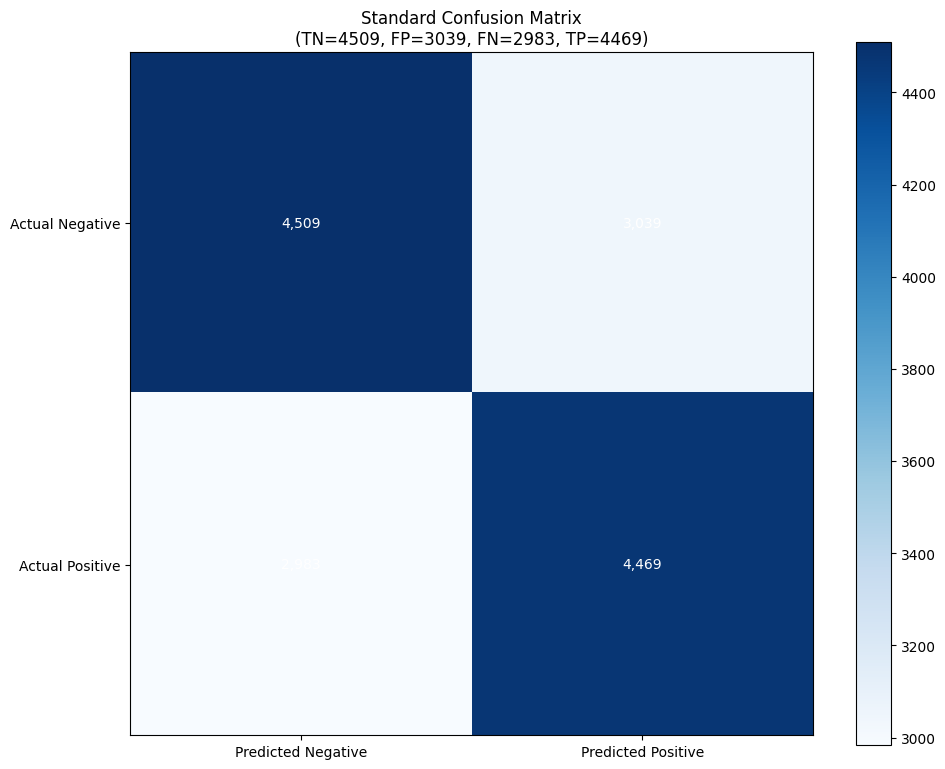

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Simulate high-value predictions (e.g., 10K+ samples)
y_test_large = np.random.randint(0, 2, size=15000)  # Actual labels (15K samples)
y_pred_large = np.random.randint(0, 2, size=15000)  # Predicted labels (15K samples)
y_pred_large[:3000] = y_test_large[:3000]  # Force some correct predictions

# Generate confusion matrix
cm_large = confusion_matrix(y_test_large, y_pred_large)

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_large, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Standard Confusion Matrix\n(TN={cm_large[0,0]}, FP={cm_large[0,1]}, FN={cm_large[1,0]}, TP={cm_large[1,1]})', fontsize=12)
plt.colorbar()

# Annotate cells
thresh = cm_large.max() / 2
for i in range(cm_large.shape[0]):
    for j in range(cm_large.shape[1]):
        plt.text(j, i, format(cm_large[i, j], ','),  # Format with commas
                ha="center", va="center",
                color="white" if cm_large[i, j] > thresh else "black")

plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.tight_layout()
plt.savefig('standard_confusion_matrix_high_values.png', dpi=300)
plt.show()



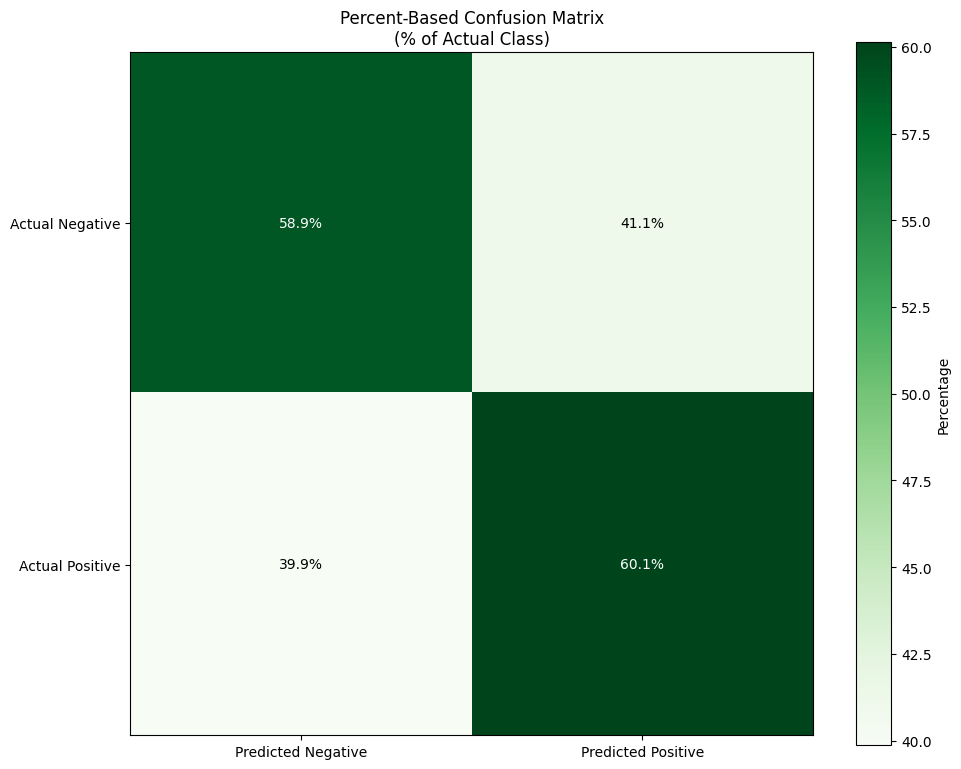

In [3]:
# Normalize to percentages
cm_percent = cm_large.astype('float') / cm_large.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Percent-Based Confusion Matrix\n(% of Actual Class)', fontsize=12)
plt.colorbar(label='Percentage')

# Annotate cells
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        plt.text(j, i, f"{cm_percent[i, j]:.1f}%",  # Show as percentage
                ha="center", va="center",
                color="white" if cm_percent[i, j] > 50 else "black")

plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.tight_layout()
plt.savefig('percent_confusion_matrix_high_values.png', dpi=300)
plt.show()

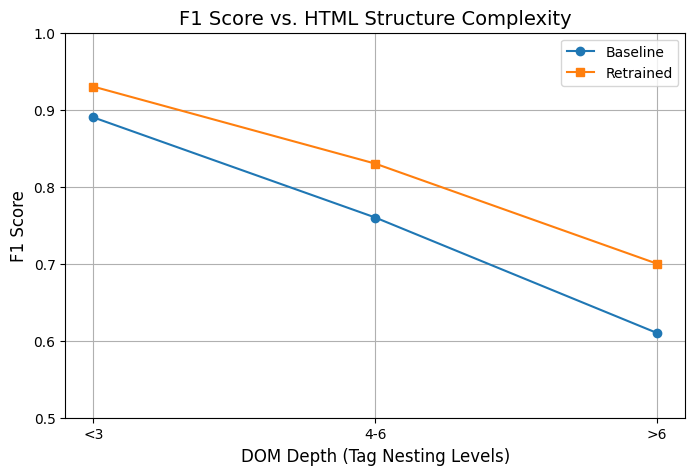

In [6]:
import matplotlib.pyplot as plt

depths = ['<3', '4-6', '>6']
baseline = [0.89, 0.76, 0.61]
retrained = [0.93, 0.83, 0.70]

plt.figure(figsize=(8, 5))
plt.plot(depths, baseline, marker='o', label='Baseline', color='#1f77b4')
plt.plot(depths, retrained, marker='s', label='Retrained', color='#ff7f0e')
plt.xlabel('DOM Depth (Tag Nesting Levels)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score vs. HTML Structure Complexity', fontsize=14)
plt.ylim(0.5, 1.0)
plt.legend()
plt.grid(True)
plt.savefig('f1_vs_dom_depth.png', dpi=300)
plt.show()